In [1]:
# Data from - https://www.clips.uantwerpen.be/conll2000/chunking/

In [2]:
def prepare_data(file_path):
    sentences = []
    tags = []
    with open(file_path, "r") as f:
        sentence = []
        pos_tags = []
        for line in f:
            line = line.strip()
            if line == "":  # Sentence boundary
                if sentence:
                    sentences.append(sentence)
                    tags.append(pos_tags)
                    sentence = []
                    pos_tags = []
            else:
                parts = line.split()
                if len(parts) >= 2:  # Ensure the line has at least word and POS tag
                    word, pos_tag = parts[0], parts[1]
                    sentence.append(word)
                    pos_tags.append(pos_tag)
        if sentence:
            sentences.append(sentence)
            tags.append(pos_tags)
    return sentences, tags

# Usage
file_path = "../practical/data/train.txt"
sentences, pos_tags = prepare_data(file_path)


In [3]:
print(sentences[0])

['Confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'September', ',', 'due', 'for', 'release', 'tomorrow', ',', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'July', 'and', 'August', "'s", 'near-record', 'deficits', '.']


In [4]:
print(pos_tags[0])

['NN', 'IN', 'DT', 'NN', 'VBZ', 'RB', 'VBN', 'TO', 'VB', 'DT', 'JJ', 'NN', 'IN', 'NN', 'NNS', 'IN', 'NNP', ',', 'JJ', 'IN', 'NN', 'NN', ',', 'VB', 'TO', 'VB', 'DT', 'JJ', 'NN', 'IN', 'NNP', 'CC', 'NNP', 'POS', 'JJ', 'NNS', '.']


In [5]:
len(sentences)

8936

In [6]:
word_vocab = {word: idx for idx, word in enumerate(set(w for s in sentences for w in s), start=1)}
word_vocab["<PAD>"] = 0  # For padding
word_vocab["<UNK>"] = len(word_vocab)  # For unknown words

tag_vocab = {tag: idx for idx, tag in enumerate(set(t for ts in pos_tags for t in ts))}

In [7]:
idx2tag = {tag_vocab[tag] : tag for tag in tag_vocab.keys()}

In [8]:
def encode_data(sentences, tags, word_vocab, tag_vocab):
    encoded_sentences = [[word_vocab.get(w, word_vocab["<UNK>"]) for w in s] for s in sentences]
    encoded_tags = [[tag_vocab[t] for t in ts] for ts in tags]
    return encoded_sentences, encoded_tags

X, y = encode_data(sentences, pos_tags, word_vocab, tag_vocab)

In [9]:
test_file_path = "../practical/data/test.txt"
t_sentences, t_pos_tags = prepare_data(test_file_path)
X_test, y_test = encode_data(t_sentences,t_pos_tags,word_vocab,tag_vocab)

In [10]:
from torch.nn.utils.rnn import pad_sequence
import torch

def pad_sequences(data, pad_value):
    return pad_sequence([torch.tensor(seq) for seq in data], batch_first=True, padding_value=pad_value)
# whats batch_first?
X_padded = pad_sequences(X, word_vocab["<PAD>"])
y_padded = pad_sequences(y, -1)  # Use -1 as the padding value for loss functions

In [11]:
X_padded.shape  == y_padded.shape

True

In [12]:
X_test_p = pad_sequences(X_test,word_vocab["<PAD>"])
y_test_p = pad_sequences(y_test,-1)

In [14]:
from torch.utils.data import DataLoader, Dataset

In [15]:
class NERData(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index],self.y[index]
        

In [16]:
traindata = NERData(X_padded,y_padded)
testdata = NERData(X_test_p,y_test_p)

In [17]:
len(traindata),len(testdata)

(8936, 2012)

In [18]:
train_loader = DataLoader(traindata,batch_size = 32, shuffle= True)
test_loader = DataLoader(testdata,batch_size=32)

In [20]:
import torch.nn as nn
import numpy as np

In [21]:
def load_glove_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

glove = load_glove_embeddings("/home/satya-tt0492/Downloads/word-embeddings/glove.6B.300d.txt")
embedding_dim = len(next(iter(glove.values())))
print(f"Embedding Dimension: {embedding_dim}")

Embedding Dimension: 300


In [22]:
embedding_matrix = []
for word in word_vocab.keys():
    if word in glove:
        embedding_matrix.append(glove[word])  # Pre-trained vector
    else:
        embedding_matrix.append(np.random.normal(size=(embedding_dim,)))  # Random for unknown words

embedding_matrix = np.array(embedding_matrix)
embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

In [23]:
class NERModel(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=300, hidden_dim=128):
        super(NERModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_tensor, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        x = self.embedding(x) 
        lstm_out,_ = self.lstm(x) 
        logits = self.fc(lstm_out)
        return logits

In [24]:
model = NERModel(vocab_size=len(word_vocab),tagset_size=len(tag_vocab))
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
losses = []

/home/satya-tt0492/anaconda3/envs/ex5/lib/python3.9/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/satya-tt0492/anaconda3/envs/ex5/lib/python3.9/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [26]:
for epoch in range(10): # total 40
    model.train()
    total_loss = 0
    for x,y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        outputs = outputs.view(-1,outputs.shape[-1])
        y = y.view(-1)

        loss = criterion(outputs,y)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 0.5505
Epoch 2, Loss: 0.5603
Epoch 3, Loss: 0.5343
Epoch 4, Loss: 0.5261
Epoch 5, Loss: 0.5160
Epoch 6, Loss: 0.5260
Epoch 7, Loss: 0.5148
Epoch 8, Loss: 0.5111
Epoch 9, Loss: 0.5084
Epoch 10, Loss: 0.5200


In [27]:
import matplotlib.pyplot as plt

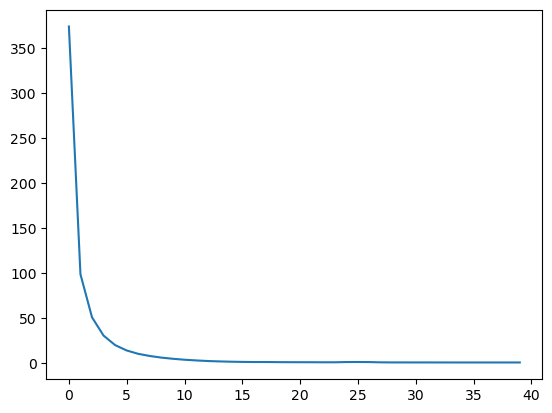

In [28]:
plt.plot(losses)

In [29]:
from sklearn.metrics import classification_report

In [30]:
model.eval()
all_preds, all_labels = [],[]
with torch.no_grad():
    for x,y in test_loader:
        outputs = model(x)
        preds = torch.argmax(outputs,dim = -1)
        # print(preds.shape,y.shape)
        all_preds.extend(preds.view(-1).tolist())
        all_labels.extend(y.view(-1).tolist())
p = len(all_labels)
q = len(all_preds)
p,q

(140840, 140840)

In [31]:
valid_indices = [i for i, label in enumerate(all_labels) if label != -1]
filtered_labels = [all_labels[i] for i in valid_indices]
filtered_preds = [all_preds[i] for i in valid_indices]

print(f"Filtered labels length: {len(filtered_labels)}")
print(f"Filtered preds length: {len(filtered_preds)}")

Filtered labels length: 47377
Filtered preds length: 47377


In [32]:
print(classification_report(filtered_labels,filtered_preds))

              precision    recall  f1-score   support

           0       0.87      0.56      0.68       130
           1       1.00      1.00      1.00      1975
           2       1.00      1.00      1.00        11
           3       0.99      1.00      1.00       814
           4       1.00      1.00      1.00      1178
           5       0.78      0.75      0.76       202
           6       1.00      1.00      1.00         4
           7       0.97      0.81      0.88       728
           8       0.33      0.17      0.22        12
           9       0.89      0.84      0.86      1104
          10       1.00      1.00      1.00        77
          11       0.87      0.88      0.88       202
          12       0.99      0.99      0.99      4020
          13       0.51      0.96      0.66      2964
          14       1.00      0.94      0.97        77
          15       0.97      0.76      0.86      4806
          16       1.00      1.00      1.00      2390
          17       1.00    

In [33]:
sent = "The quick brown fox jumps over the lazy dog"
sent = sent.split()
inp = torch.tensor([word_vocab.get(word,word_vocab["<UNK>"]) for word in sent])
outputs = model(inp)

In [34]:
output = torch.argmax(outputs,dim=-1).view(-1)

In [35]:
output = output.tolist()
tags = [idx2tag[idx] for idx in output]

In [36]:
tags

['DT', 'JJ', 'JJ', 'NN', 'JJ', 'IN', 'DT', 'JJ', 'NN']